# Get our environment set up

The first thing we'll need to do is load in the libraries and datasets we'll be using. We'll working with one datasets containing information on air quality conditon (Humidity, temperature, pressure, CO2 levels) and numbers of microparticles (between 0.1 and 5 μm in size by m3 of air) in an operating room .

In [119]:
# Modules we'll use
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
import datetime as dt

# Read in our data as a Pandas DataFrame
df = pd.read_csv("/content/gams_indoor.csv", parse_dates=True, index_col="ts")

# set theme with seaborn
sns.set_theme(style="darkgrid")

# Get sample of our dataset

We simply display the first 5 row of our data.

In [122]:
df.head()

,co2,humidity,pm10,pm25,temperature,voc
ts,,,,,,
2016-11-21 00:47:03,708.0,72.09,10.2,9.0,20.83,0.062
2016-11-21 00:48:03,694.0,70.95,10.9,10.1,21.01,0.062
2016-11-21 00:49:03,693.0,69.12,10.2,9.9,21.20,0.062
2016-11-21 00:50:03,692.0,68.83,9.6,9.6,21.37,0.062
2016-11-21 00:51:03,690.0,68.60,9.4,8.4,21.49,0.062


In [135]:
df.tail()

,co2,humidity,pm10,pm25,temperature,voc
ts,,,,,,
2017-03-28 09:26:03,1359.0,39.55,6.3,4.4,26.93,0.148
2017-03-28 09:27:03,1350.0,39.49,5.6,4.2,26.92,0.152
2017-03-28 09:28:03,1353.0,39.42,6.3,4.6,26.91,0.147
2017-03-28 09:29:03,1348.0,39.55,5.7,4.3,26.92,0.148
2017-03-28 09:30:03,1363.0,39.55,5.8,4.2,26.90,0.139


In [123]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 135099 entries, 2016-11-21 00:47:03 to 2017-03-28 09:30:03
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   co2          135099 non-null  float64
 1   humidity     135099 non-null  float64
 2   pm10         135099 non-null  float64
 3   pm25         135099 non-null  float64
 4   temperature  135099 non-null  float64
 5   voc          135099 non-null  float64
dtypes: float64(6)
memory usage: 7.2 MB


# Get humidity time serie

In the first place, we need to explain how a time serie works. To illustrate that, we will test a simple RNN on a time serie with humidity. This new dataframe will be our training dataset to predict the future measure of humidity. 

In [126]:
# We create a new dataFrame for humidity 
humidity_df = df[['humidity']]
humidity_df.info()
humidity_df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 135099 entries, 2016-11-21 00:47:03 to 2017-03-28 09:30:03
Data columns (total 1 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   humidity  135099 non-null  float64
dtypes: float64(1)
memory usage: 2.1 MB


,humidity
ts,
2016-11-21 00:47:03,72.09
2016-11-21 00:48:03,70.95
2016-11-21 00:49:03,69.12
2016-11-21 00:50:03,68.83
2016-11-21 00:51:03,68.60


(array([736289.03472222, 736289.04166667, 736289.04861111, 736289.05555556,
        736289.0625    , 736289.06944444, 736289.07638889, 736289.08333333]),
 <a list of 8 Text major ticklabel objects>)

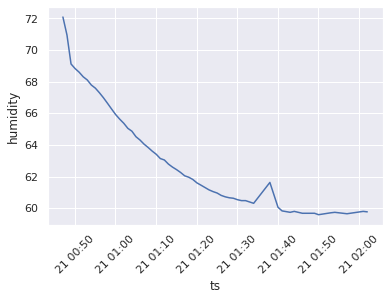

In [240]:
# Almost a sequence for 1 hour 
sns.lineplot(data=humidity_df[:60], x="ts", y='humidity')
plt.xticks(rotation=45)

(array([736416.35416667, 736416.36111111, 736416.36805556, 736416.375     ,
        736416.38194444, 736416.38888889, 736416.39583333]),
 <a list of 7 Text major ticklabel objects>)

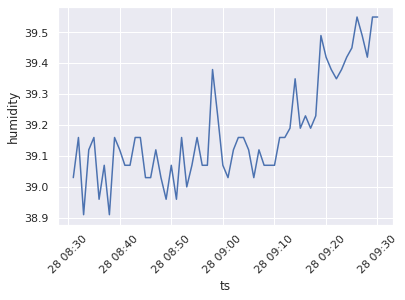

In [241]:
sns.lineplot(data=humidity_df.tail(60), x="ts", y='humidity')
plt.xticks(rotation=45)

(array([736289.   , 736289.125, 736289.25 , 736289.375, 736289.5  ,
        736289.625, 736289.75 , 736289.875, 736290.   ]),
 <a list of 9 Text major ticklabel objects>)

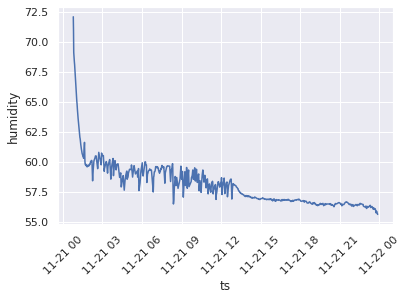

In [242]:
# Almost a sequence for 1 day 
sns.lineplot(data=humidity_df[:700], x="ts", y='humidity')
plt.xticks(rotation=45)

# How to get our training and test dataset

We need to extract some data from the end of the dataset to build our test dataset and keep the rest to build the training dataset. 

For time ressources purpose, we only use 1 week of data to train and test our model. 

In [244]:
humidity_day_df = humidity_df[:700]
humidity_day_df

,humidity
ts,
2016-11-21 00:47:03,72.09
2016-11-21 00:48:03,70.95
2016-11-21 00:49:03,69.12
2016-11-21 00:50:03,68.83
2016-11-21 00:51:03,68.60
...,...
2016-11-21 23:42:02,56.10
2016-11-21 23:46:02,55.76
2016-11-21 23:48:02,55.90


In [245]:
# The size of the dataset ?
len(humidity_day_df)

700

In [247]:
# the size on our test dataset must be greater than 1 hour (almost 1.5)
test_size = 45

In [248]:
len(humidity_day_df) - test_size

655

In [249]:
# We get our slice point (from the end of the dataset)
test_ind = len(humidity_day_df) - test_size
print(test_ind)

655


In [250]:
# We get our training dataset
train = humidity_day_df.iloc[:test_ind]
train

,humidity
ts,
2016-11-21 00:47:03,72.09
2016-11-21 00:48:03,70.95
2016-11-21 00:49:03,69.12
2016-11-21 00:50:03,68.83
2016-11-21 00:51:03,68.60
...,...
2016-11-21 22:19:02,56.42
2016-11-21 22:20:02,56.35
2016-11-21 22:22:02,56.46


In [252]:
# We get our test dataset
test = humidity_day_df.iloc[test_ind:]
test

,humidity
ts,
2016-11-21 22:28:02,56.46
2016-11-21 22:29:02,56.46
2016-11-21 22:30:02,56.42
2016-11-21 22:32:02,56.49
2016-11-21 22:33:02,56.55
2016-11-21 22:41:02,56.49
2016-11-21 22:42:02,56.49
2016-11-21 22:44:02,56.46
2016-11-21 22:45:02,56.46



# Preprocessing Data 

Now we get our training and test dataset we can preprocess our data. 

## Data normalization

Many machine learning algorithms perform better when numerical input variables are scaled to a standard range.

In [215]:
from sklearn.preprocessing import MinMaxScaler

In [253]:
# We create an instance of MinMaxScaler
scaler = MinMaxScaler()

In [254]:
scaler.fit(train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [255]:
scaled_train = scaler.transform(train)
len(scaled_train)

655

In [256]:
scaled_test = scaler.transform(test)
len(scaled_test)

45

## Time series generator

Here, our goal is to produce some batch for training and validation phase.

In [222]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [257]:
len(test)

45

In [259]:
# batch length need to be smaller than test dataset size, so we can use 700 (almost 1 day)
length = 30
# one batch at the time
batch_size = 1

In [260]:
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=batch_size)

In [261]:
# Our dataset of training contains 121589 point of data
len(scaled_train)

655

In [262]:
len(generator)

625

In [263]:
# Our first batch
X, y = generator[0]

In [271]:
# If we had this sequence of data, ...
x

array([[[0.        , 1.        ],
        [0.        , 0.97725459],
        [0.        , 0.94074222],
        [0.        , 0.93495611],
        [0.        , 0.93036712],
        [0.        , 0.92458101],
        [0.        , 0.92059058],
        [0.        , 0.91420591],
        [0.        , 0.91021548],
        [0.        , 0.90442937],
        [0.        , 0.89804469],
        [0.        , 0.89106145],
        [0.        , 0.88387869],
        [0.        , 0.87689545],
        [0.        , 0.87110934],
        [0.        , 0.86592179],
        [0.        , 0.85953711],
        [0.        , 0.85594573],
        [0.        , 0.84896249],
        [0.        , 0.84477255],
        [0.        , 0.839585  ],
        [0.        , 0.83539505],
        [0.        , 0.83080607],
        [0.        , 0.82681564],
        [0.        , 0.82142857]]])

In [270]:
# Then, we can predit that the next one is this value
y

array([[0.3653603]])

In [266]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [267]:
# We use only one feature (humidity)
n_features = 1

In [268]:
# We define the model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [272]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [273]:
from tensorflow.keras.callbacks import EarlyStopping

In [274]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [275]:
validation_generator = TimeseriesGenerator(scaled_test,scaled_test, length=length, batch_size=1)

In [276]:
model.fit(generator,epochs=20,
                    validation_data=validation_generator,
                   callbacks=[early_stop])

Epoch 1/20
625/625 [==============================] - 8s 12ms/step - loss: 0.0012 - val_loss: 5.1831e-04
Epoch 2/20
625/625 [==============================] - 7s 11ms/step - loss: 7.4458e-04 - val_loss: 7.2410e-04
Epoch 3/20
625/625 [==============================] - 7s 11ms/step - loss: 7.6490e-04 - val_loss: 8.5899e-04


In [277]:
losses = pd.DataFrame(model.history.history)

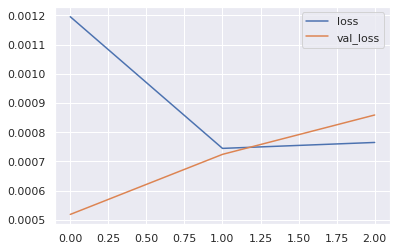

In [278]:
losses.plot()

# Data evaluation

We need to build a new array with predictions for humidity for the next batch (in other words, for the next hour).

In [288]:
len(test)

45

In [283]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    # we get the prediction for th next timestamp 
    current_pred = model.predict(current_batch)[0]
    # we store the prediction
    test_predictions.append(current_pred) 
    # we update the batch to include the prediction (t+1) to predict at the iteration the next value (t+2)
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

# Reverse transformation

Now we need to reverse the normalization process to get our values. 

In [284]:
true_predictions = scaler.inverse_transform(test_predictions)

In [286]:
test['Predictions'] = true_predictions

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [289]:
# we get our table with predictions for the next hour 
test

,humidity,Predictions
ts,,
2016-11-21 22:28:02,56.46,56.634910
2016-11-21 22:29:02,56.46,56.671175
2016-11-21 22:30:02,56.42,56.705638
2016-11-21 22:32:02,56.49,56.738504
2016-11-21 22:33:02,56.55,56.769748
2016-11-21 22:41:02,56.49,56.799376
2016-11-21 22:42:02,56.49,56.827534
2016-11-21 22:44:02,56.46,56.854697
2016-11-21 22:45:02,56.46,56.881978


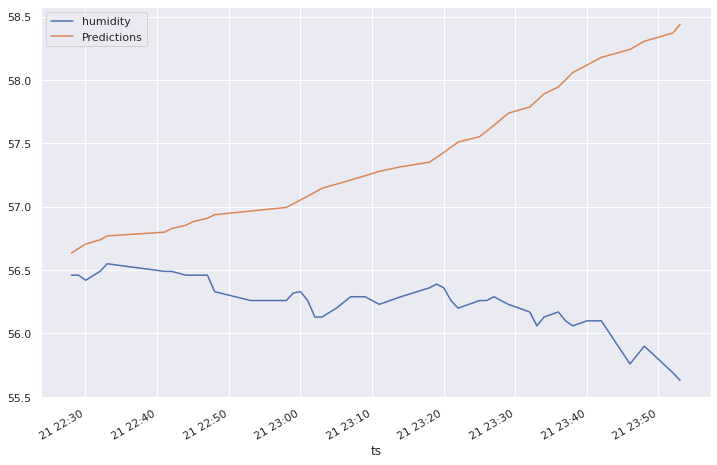

In [290]:
test.plot(figsize=(12,8))